In [1]:
#!pip3 install jieba
#!pip install tqdm 
!pip install keras
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4 MB 51 kB/s 
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
     |████████████████████████████████| 1.3 MB 6.8 MB/s 
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     |████████████████████████████████| 3.8 MB 4.4 MB/s 
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached wrapt-1.12.1.tar.gz (27 kB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
     |████████████████████████████████| 10.6 MB 5.5 MB/s 
  Using cached absl_py-0.11.0-py3-none-any.whl (127 kB)
     |████████████████████████████████| 20.1 MB 3.5 MB/s 
     |████████████████████████████████| 2.9 MB 4.5 MB/s 
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached google_auth_oauthlib-0.4.2-py2.py3-none-any.whl (18 kB)
  Using cached Markdown-3.3.3-py3-none-any.whl (96 kB)
  Using 

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [1]:
import jieba
import string
import re
from tqdm import tqdm
#from numpy import array, argmax, random, take
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Our data is a text file (.txt) of English-German sentence pairs. First, we will read the file using the function defined below

In [4]:
# function to read raw text file
def read_text(filename):
        
# this is a bad practice to close files manually
  with open(filename, mode='rt', encoding='utf-8') as file:
    text = file.read()

  return text

In [5]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [6]:
#!unzip -uq "/content/drive/My Drive/Colab Notebooks/cmn-eng.zip" -d "/content/drive/My Drive/Colab Notebooks/"

In [7]:
pathURL = '/home/henri/Documents/Lighthouse-lab/Databases/w9-d4-db/cmn.txt' 
data = read_text(pathURL)
zhongWen_eng = to_lines(data)
zhongWen_eng = np.array(zhongWen_eng)

In [8]:
# the shape of 3 means english,chinese, translator 
zhongWen_eng.shape

(23610, 3)

In [9]:
zhongWen_eng[:,:2,][:10]

array([['Hi.', '嗨。'],
       ['Hi.', '你好。'],
       ['Run.', '你用跑的。'],
       ['Wait!', '等等！'],
       ['Wait!', '等一下！'],
       ['Hello!', '你好。'],
       ['I won!', '我赢了。'],
       ['Oh no!', '不会吧。'],
       ['Cheers!', '乾杯!'],
       ['Got it?', '你懂了吗？']], dtype='<U163')

In [10]:
zhongWen_eng = zhongWen_eng[:,:2,]

In [11]:
# Remove punctuation
zhongWen_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in zhongWen_eng[:,0]]
# not so sure of the punctuation side of chinese is the same as string.punctuation.
punc = "！？｡。＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏."
zhongWen_eng[:,1] = [s.translate(str.maketrans('', '', punc)) for s in zhongWen_eng[:,1]]

In [12]:
zhongWen_eng[:10]

array([['Hi', '嗨'],
       ['Hi', '你好'],
       ['Run', '你用跑的'],
       ['Wait', '等等'],
       ['Wait', '等一下'],
       ['Hello', '你好'],
       ['I won', '我赢了'],
       ['Oh no', '不会吧'],
       ['Cheers', '乾杯!'],
       ['Got it', '你懂了吗']], dtype='<U163')

Punctuation in Chinese (unicode)

In [13]:
punc = "！？｡。＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏."
line = "测试。。去除标点。。，、！"
print(re.sub(rf"[{punc}s]+","", line)) #formatted string and regex at the same time? (rf?)

测试去除标点


Lowering characters in English, but that doesn't apply in Chinese.

In [14]:
for i in range(len(zhongWen_eng)):
    zhongWen_eng[i,0] = zhongWen_eng[i,0].lower()

Learning how to split unicode language since split will not due

In [15]:
from re import compile as _Re

_unicode_chr_splitter = _Re( '(?s)((?:[\ud800-\udbff][\udc00-\udfff])|.)' ).split

def split_unicode_chrs( text ):
  return [ chr for chr in _unicode_chr_splitter( text ) if chr ]

In [16]:
split_unicode_chrs('你好。')

['你', '好', '。']

In [17]:
jieba.enable_paddle()

Installing paddle-tiny, please wait a minute......
Paddle enabled successfully......


23610it [00:45, 520.23it/s]


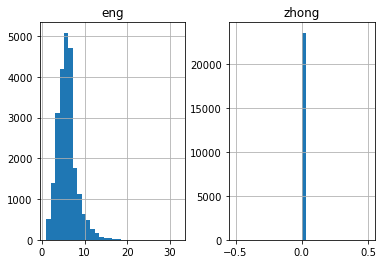

In [18]:
# empty lists
eng_l = []
zhong_l = []
jeibaZhongDict = dict()
# populate the lists with sentence lengths
for i in zhongWen_eng[:,0]:
      eng_l.append(len(i.split()))

# for i in zhongWen_eng[:,1]:
#       zhong_l.append(len(split_unicode_chrs(i)))

for index,line in tqdm(np.ndenumerate(zhongWen_eng[:,1])):
  seg_list = jieba.cut(line,use_paddle=True)
  jeibaZhongDict[index] = list(seg_list)
  zhong_l.append(len(list(seg_list)))


length_df = pd.DataFrame({'eng':eng_l, 'zhong':zhong_l})

length_df.hist(bins = 30)
plt.show()

Next, vectorize our text data by using Keras’s Tokenizer() class. It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length.

In [19]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [20]:
# prepare language tokenizer
eng_tokenizer = tokenization(zhongWen_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1 # + 1 otherwise the fitting of the model will thrown an error
eng_length = 12
zhong_tokenizer = tokenization(jeibaZhongDict.values())
zhong_vocab_size = len(zhong_tokenizer.word_index) +1 # error was that I was using the english tokeniser instead of the zhinese one
zhong_length = 12
print('English Vocabulary Size: %d' % eng_vocab_size)
print('中文 Vocabulary Size: %d' % zhong_vocab_size)

English Vocabulary Size: 6704
中文 Vocabulary Size: 14105


In [1]:
zhong_tokenizer.word_index

NameError: name 'zhong_tokenizer' is not defined

The fact that they are of the same length makes me think that there isn't enough training data.

In [21]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

## Model building

In [26]:
!pip install -U scikit-learn
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(zhongWen_eng, test_size=0.1, random_state = 12)

     |████████████████████████████████| 6.8 MB 8.1 MB/s 
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Using cached joblib-0.17.0-py3-none-any.whl (301 kB)


In [27]:
# prepare training data
trainX = encode_sequences(zhong_tokenizer, zhong_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(zhong_tokenizer, zhong_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [28]:
from keras.layers import Dropout
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(Dropout(0.8))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dropout(0.8))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [29]:
# model compilation
#with tpu_strategy.scope():
model = define_model(zhong_vocab_size, eng_vocab_size, zhong_length, eng_length, 512)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 512)           7221760   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense (Dense)                (None, 8, 6704)           3439152   
Total params: 14,859,312
Trainable params: 14,859,312
Non-trainable params: 0
_________________________________________________________________


In [31]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [32]:
rms = optimizers.Adam(lr=0.03)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [33]:
trainY.shape[0]

18888

In [34]:
trainY.reshape(trainY.shape[0], trainY.shape[1], 1).shape

(18888, 8, 1)

In [35]:
trainX.shape

(18888, 20)

In [ ]:
filename = 'model.h1.12_nov_20'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=500, batch_size=16, validation_split = 0.3,callbacks=[checkpoint], 
                    verbose=1)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
model = load_model('model.h1.12_nov_20')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [ ]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [ ]:
preds_text = []

for i in tqdm(preds):
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
# print 15 rows randomly
pred_df.sample(15)